In [27]:
!pip install scikit-learn

In [28]:
!pip install caer

In [29]:
!pip install caer canaro

In [30]:
!pip install matplotlib

In [32]:
!pip install tensorflow keras

In [59]:
import matplotlib.pyplot as plt
import os
import gc

import torch
import cv2 as cv
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
import caer
import canaro

In [60]:
img_size=(180,180)
channels = 1
char_path= 'Data/simpsons_dataset'

In [61]:
char_dict={}
for char in os.listdir(char_path):
    char_dict[char]=len(os.listdir(os.path.join(char_path,char)))
char_dict = caer.sort_dict(char_dict, descending=True)
char_dict

[('homer_simpson', 2246),
 ('ned_flanders', 1454),
 ('moe_szyslak', 1452),
 ('lisa_simpson', 1354),
 ('bart_simpson', 1342),
 ('marge_simpson', 1291),
 ('krusty_the_clown', 1206),
 ('principal_skinner', 1194),
 ('charles_montgomery_burns', 1193),
 ('milhouse_van_houten', 1079),
 ('chief_wiggum', 986),
 ('abraham_grampa_simpson', 913),
 ('sideshow_bob', 877),
 ('apu_nahasapeemapetilon', 623),
 ('kent_brockman', 498),
 ('comic_book_guy', 469),
 ('edna_krabappel', 457),
 ('nelson_muntz', 358),
 ('lenny_leonard', 310),
 ('mayor_quimby', 246),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('groundskeeper_willie', 121),
 ('barney_gumble', 106),
 ('selma_bouvier', 103),
 ('carl_carlson', 98),
 ('ralph_wiggum', 89),
 ('patty_bouvier', 72),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('snake_jailbird', 55),
 ('cletus_spuckler', 47),
 ('rainier_wolfcastle', 45),
 ('agnes_skinner', 42),
 ('simpsons_dataset', 42),
 ('sideshow_mel', 40),
 ('otto_mann', 32),
 ('fat_tony', 27),
 (

In [84]:
chars = []
cnt=0
for i in char_dict:
    chars.append(i[0])
    cnt+=1
    if cnt>=2:
        break
chars

['homer_simpson', 'ned_flanders']

In [85]:
#Создание тренировочных данных
train=caer.preprocess_from_dir(char_path, chars, channels=channels, IMG_SIZE=img_size, isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] At 2000 files
[INFO] 2246 files found in 0.01001119613647461s
[INFO] At 1000 files
[INFO] 1454 files found in 0.007002353668212891s
----------------------------------------------
[INFO] 3700 files preprocessed! Took 0m 8s


In [86]:
len(train)

3700

<function matplotlib.pyplot.show(close=None, block=None)>

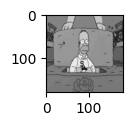

In [87]:
plt.figure(figsize=(1,1))
plt.imshow(train[0][0], cmap='gray')
plt.show

In [88]:
featureSet, labels = caer.sep_train(train, IMG_SIZE=img_size)

In [89]:
featureSet = caer.normalize(featureSet)
labels = to_categorical(labels, len(chars))

In [90]:
x_train, x_val, y_train, y_val = caer.train_val_split(featureSet, labels, val_ratio=0.1)

In [91]:
# x_train.shape
# y_train.shape

In [95]:
# # Создаем модель нейронной сети
# model = Sequential()

# # Добавляем сверточный слой
# model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(180, 180, 1)))

# # Добавляем слой подвыборки
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# # Добавляем второй сверточный слой
# model.add(Conv2D(64, (3, 3), activation='relu'))

# # Добавляем второй слой подвыборки
# model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))

# # Преобразуем двумерные данные в одномерные
# model.add(Flatten())

# # Добавляем полносвязный слой
# model.add(Dense(64, activation='relu'))

# # Добавляем выходной слой
# model.add(Dense(3, activation='softmax'))

# # optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00001, decay=1e-7, momentum=0.7, nesterov=True)

# # Компилируем модель
# # model.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()
class ConvNN(tf.keras.Model):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(64,3,activation='relu', input_shape=(180,180,1))
        self.max1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(64,3,activation='relu')
        self.max2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(64, activation='relu')
        self.d2 = tf.keras.layers.Dense(2, activation='relu')
    def call(self,x):
        x = self.conv1(x)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        return x

model = ConvNN()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "conv_nn_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Layer (type)                       ┃ Output Shape                  ┃     Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                 │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_18 (MaxPooling2D)    │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ conv2d_19 (Conv2D)                 │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ max_pooling2d_19 (MaxPooling2D)    │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ flatten_9 (Flatten)                │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_18 (Dense)                   │ ?                             │ 0 (unbuilt) │
├────────────────────────────────────┼───────────────────────────────┼─────────────┤
│ dense_19 (Dense)                   │ ?                             │ 0 (unbuilt) │
└────────────────────────────────────┴───────────────────────────────┴─────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [93]:
del train
del featureSet
del labels
gc.collect()

BATCH_SIZE=5
EPOCHS=10
# if torch.cuda.is_available():
#     print("CUDA доступно на вашем компьютере.")
# else:
#     print("CUDA не доступно на вашем компьютере.")

In [96]:
datagen = ImageDataGenerator(rotation_range=30, width_shift_range=0.1, height_shift_range=0.1
                             , zoom_range=0.2)
train_gen = datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)

callbacks_list=[LearningRateScheduler(canaro.lr_schedule)]

# optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.00001, decay=1e-7, momentum=0.7, nesterov=True)
# len(x_train)
# len(y_val)

training=model.fit(train_gen, steps_per_epoch=len(x_train)//BATCH_SIZE, epochs=EPOCHS, validation_data=(x_val, y_val),
                   validation_steps=len(y_val)//BATCH_SIZE, callbacks=callbacks_list)
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

Epoch 1/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 118s 175ms/step - accuracy: 0.6115 - loss: nan - val_accuracy: 0.6469 - val_loss: nan - learning_rate: 0.0100
Epoch 2/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4000 - loss: nan - val_accuracy: 0.6469 - val_loss: nan - learning_rate: 0.0100
Epoch 3/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 109s 164ms/step - accuracy: 0.5950 - loss: nan - val_accuracy: 0.6469 - val_loss: nan - learning_rate: 0.0100
Epoch 4/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 1.0000 - loss: nan - val_accuracy: 0.6469 - val_loss: nan - learning_rate: 0.0100
Epoch 5/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 108s 162ms/step - accuracy: 0.6057 - loss: nan - val_accuracy: 0.6469 - val_loss: nan - learning_rate: 0.0100
Epoch 6/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4000 - loss: nan - val_accuracy: 0.6469 - val_loss: nan - learning_rate: 0.0100
Epoch 7/10
665/665 ━━━━━━━━━━━━━━━━━━━━ 109s 163ms/step - accuracy: 0.6026 - loss: nan - val_accuracy: 0.6469 - 

AttributeError: Can't pickle local object 'Layer._initializer_tracker.<locals>.<lambda>'

In [104]:
val_datagen = canaro.generators.imageDataGenerator()
val_gen = val_datagen.flow(x_val, y_val, batch_size=BATCH_SIZE)
model.evaluate(val_gen)

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6329 - loss: nan


[nan, 0.6469002962112427]

In [105]:
img1 = cv.imread('Data/kaggle_simpson_testset/kaggle_simpson_testset/ned_flanders_12.jpg')
def prepare(image, img_size):
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    image = (image/10).astype('float16')
    image = cv.resize(image, img_size)
    image = caer.reshape(image, img_size, 1)
    return image

In [106]:
img_size = (180,180)
predictions = model.predict(prepare(img1, img_size))

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4030: error: (-215:Assertion failed) func != 0 in function 'cv::hal::resize'


In [100]:
print(chars[np.argmax(predictions[0])])

homer_simpson
